# One-shot Vertical Federated Learning with CIFAR-10

### Setup

Install the required packages for training in the current Jupyter kernel:

Set `PYTHONPATH` to include custom files of this example and some reused files from the [CIFAR-10](https://github.com/NVIDIA/NVFlare/tree/main/examples/advanced/cifar10) examples:

In [1]:
import sys
# !{sys.executable} -m pip install -r ./requirements.txt

In [2]:
import os
sys.path.append(os.path.join(os.getcwd(), "src"))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "examples", "advanced", "cifar10"))

In [3]:
try:
    from oneshotVFL.cifar10_vertical_data_splitter import Cifar10VerticalDataSplitter
except ImportError as e:
     raise ImportError("PYTHONPATH is not set properly") from e

## 1. Download and split the CIFAR-10 dataset
To simulate a vertical split dataset, we first download the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and distribute it between the two clients, assuming an `OVERLAP` of 10,000 samples between the two clients' datasets.

In [4]:
SPLIT_DIR = "/tmp/cifar10_vert_splits"
OVERLAP = "10000"
%run ./cifar10_split_data_vertical.py --split_dir $SPLIT_DIR --overlap $OVERLAP

INFO:Cifar10VerticalDataSplitter:[identity=local, run=_]: Partition CIFAR-10 dataset into vertically with 10000 overlapping samples.
Files already downloaded and verified
INFO:Cifar10VerticalDataSplitter:[identity=local, run=_]: save /tmp/cifar10_vert_splits/overlap.npy
INFO:Cifar10VerticalDataSplitter:[identity=local, run=_]: save /tmp/cifar10_vert_splits/site-1.npy
INFO:Cifar10VerticalDataSplitter:[identity=local, run=_]: save /tmp/cifar10_vert_splits/site-2.npy


## 2. Run private set intersection
We are using NVFlare's FL simulator to run the following experiments.

In order to find the overlapping data indices between the different clients participating in split learning, 
we randomly select an subset of the training indices.

In [5]:
import os
from nvflare import SimulatorRunner

simulator = SimulatorRunner(
    job_folder=f"jobs/cifar10_psi",
    workspace="/tmp/nvflare/cifar10_psi",
    n_clients=2,
    threads=2
)
run_status = simulator.run()
print("Simulator finished with run_status", run_status)

DEBUG:MPM:=========== MPM: started to run forever
2023-06-12 17:05:42,171 - SimulatorRunner - INFO - Create the Simulator Server.
2023-06-12 17:05:42,176 - Cell - INFO - server: creating listener on tcp://0:41853
2023-06-12 17:05:42,177 - Cell - INFO - server: created backbone external listener for tcp://0:41853
2023-06-12 17:05:42,178 - ConnectorManager - INFO - 129316: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2023-06-12 17:05:42,179 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:50741] is starting
2023-06-12 17:05:42,680 - Cell - INFO - server: created backbone internal listener for tcp://localhost:50741
2023-06-12 17:05:42,681 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:41853] is starting
2023-06-12 17:05:42,756 - nvflare.fuel.hci.server.hci - INFO - Starting Admin Server localhost on Port 39145
2023-06-12 17:05:42,757 - SimulatorRunner - INFO - Deploy the Apps.
2023-06-12 17:05:4

The result will be saved on each client's working directory in `intersection.txt`.

We can check the correctness of the result by comparing to the generate ground truth overlap, saved in `overlap.npy`.

### Check the PSI result
We can check the correctness of the result by comparing to the generate ground truth overlap, saved in overlap.npy.

In [6]:
import os
import numpy as np

gt_overlap = np.load(os.path.join(SPLIT_DIR, "overlap.npy"))

psi_overlap_1 = np.loadtxt("/tmp/nvflare/cifar10_psi/simulate_job/site-1/psi/intersection.txt")
psi_overlap_2 = np.loadtxt("/tmp/nvflare/cifar10_psi/simulate_job/site-2/psi/intersection.txt")
                     
print("gt_overlap", gt_overlap, f"n={len(gt_overlap)}")
print("psi_overlap_1", psi_overlap_1, f"n={len(psi_overlap_1)}")
print("psi_overlap_2", psi_overlap_2, f"n={len(psi_overlap_2)}")

intersect_1 = np.intersect1d(psi_overlap_1, gt_overlap, assume_unique=True)
intersect_2 = np.intersect1d(psi_overlap_2, gt_overlap, assume_unique=True)

print(f"Found {100*len(intersect_1)/len(gt_overlap):.1f}% of the overlapping sample ids for site-1.")
print(f"Found {100*len(intersect_2)/len(gt_overlap):.1f}% of the overlapping sample ids for site-2.")

gt_overlap [11841 19602 45519 ... 47278 37020  2217] n=10000
psi_overlap_1 [ 4481. 45431. 46253. ... 34846.   179.  7277.] n=10000
psi_overlap_2 [38639. 10733. 31911. ... 12172. 46167.   865.] n=10000
Found 100.0% of the overlapping sample ids for site-1.
Found 100.0% of the overlapping sample ids for site-2.


## 3. Run simulated Oneshot VFL experiments
Next we use the `intersection.txt` files to align the datasets on each participating site in order to do split learning.
The [config_fed_client.json](./jobs/cifar10_splitnn/site-1/config/config_fed_client.json) takes as input the previously generated intersection file for each site.
```
    {
        "id": "cifar10-learner",
        "path": "pt.learners.cifar10_learner_splitnn.CIFAR10LearnerSplitNN",
        "args": {
            "dataset_root": "{DATASET_ROOT}",
            "intersection_file": "{INTERSECTION_FILE}",
            "lr": 1e-2,
            "model": {"path": "pt.networks.split_nn.SplitNN", "args":  {"split_id":  0}},
            "timeit": true
        }
    }
```
To set the filename automatically, run:

In [7]:
!for i in {1..2}; \
do \
  CONFIG_FILE=jobs/cifar10_oneshotVFL/site-${i}/config/config_fed_client.json; \
  INTERSECTION_FILE=/tmp/nvflare/cifar10_psi/simulate_job/site-${i}/psi/intersection.txt; \
  python3 ./set_intersection_file.py --config_file ${CONFIG_FILE} --intersection_file ${INTERSECTION_FILE}; \
done

Modified jobs/cifar10_oneshotVFL/site-1/config/config_fed_client.json to use INTERSECTION_FILE=/tmp/nvflare/cifar10_psi/simulate_job/site-1/psi/intersection.txt
Modified jobs/cifar10_oneshotVFL/site-2/config/config_fed_client.json to use INTERSECTION_FILE=/tmp/nvflare/cifar10_psi/simulate_job/site-2/psi/intersection.txt


To run the experiment, execute:

In [8]:
import os
from nvflare import SimulatorRunner

simulator = SimulatorRunner(
    job_folder=f"jobs/cifar10_oneshotVFL",
    workspace="/tmp/nvflare/cifar10_oneshotVFL",
    n_clients=2,
    threads=2
)
run_status = simulator.run()
print("Simulator finished with run_status", run_status)

DEBUG:MPM:=========== MPM: started to run forever
2023-06-12 17:06:41,716 - SimulatorRunner - INFO - Create the Simulator Server.
2023-06-12 17:06:41,720 - Cell - INFO - server: creating listener on tcp://0:51919
2023-06-12 17:06:41,721 - Cell - INFO - server: created backbone external listener for tcp://0:51919
2023-06-12 17:06:41,721 - ConnectorManager - INFO - 130375: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2023-06-12 17:06:41,722 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:47087] is starting
2023-06-12 17:06:42,223 - Cell - INFO - server: created backbone internal listener for tcp://localhost:47087
2023-06-12 17:06:42,225 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:51919] is starting
2023-06-12 17:06:42,305 - nvflare.fuel.hci.server.hci - INFO - Starting Admin Server localhost on Port 55241
2023-06-12 17:06:42,306 - SimulatorRunner - INFO - Deploy the Apps.
2023-06-12 17:06:4

Visulaize the local training curve on the data side.

[0.104, 0.5051, 0.7027, 0.7979, 0.8809, 0.9289, 0.9533, 0.9648, 0.9636, 0.9776, 0.9772, 0.9855, 0.9885, 0.9841, 0.9892, 0.9925, 0.9883, 0.9906, 0.9962, 0.9939]


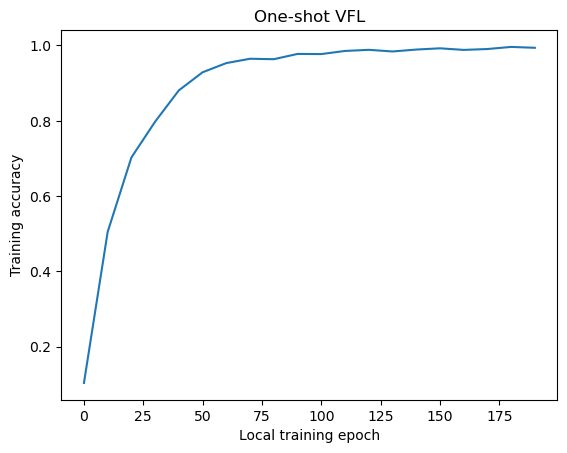

In [1]:
from plt_valid import plot_acc

plot_acc("/tmp/nvflare/cifar10_oneshotVFL")